In [1]:
%pip install --quiet mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import collections

In [3]:
#returns percentage of those who knew rumor
def perc_know(model):
  return (sum(1 for agent in model.schedule.agents if agent.heardRumor))/len(model.schedule.agents)

class Person(mesa.Agent):
  def __init__(self, unique_id, model, spreadChance, trPStart, trPRange):
    super().__init__(unique_id, model)
    self.heardRumor = False
    self.trustLevels = {}
    self.spreadChance = spreadChance
    self.trPStart = trPStart
    self.trPRange = trPRange

  def spread_rumor(self):
    #calculates if rumor will spread based on spread chance
    willSpread = np.random.choice([0,1], p = [self.spreadChance, 1-self.spreadChance])
    #only spreads if agent knows rumor and willSpread is 0
    if (self.heardRumor and willSpread == 0):
      #looks through neighbors for those who don't know
      neighbors = self.model.grid.get_neighbors(self.pos, moore = True, radius =1, include_center = False)
      potentialSpread = [neighbor for neighbor in neighbors if neighbor.heardRumor == False]
      #picks random neighbor, and if neighbor has more than 50% trust in agent, rumor spreads
      if potentialSpread:
        target = np.random.choice(potentialSpread)
        if target.trustLevels.get(self.unique_id, 0.5) > 0.5:
          target.heardRumor = True
        else:
          target.heardRumor = False

#generates trust value for agent and neighbors and adds key:value pair to both trust dictionaries
  def genTrust(self):
    neighbors = self.model.grid.get_neighbors(self.pos, moore = True, radius =1, include_center = False)
    for neighbor in neighbors:
      if neighbor.unique_id not in self.trustLevels:
        randTrust = max(0.1, np.random.normal(self.trPStart,self.trPRange))
        self.trustLevels[neighbor.unique_id] = randTrust
        neighbor.trustLevels[self.unique_id] = randTrust
#moves to random area in neighborhood
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
        self.pos, moore = True, include_center = False
    )
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)

  def step(self):
    self.move()
    self.genTrust()
    self.spread_rumor()


class RumorModel(mesa.Model):
  def __init__(self, width, height, N, numRumored, spreadChance, trPStart, trPRange):
    self.num_agents = N
    self.grid = mesa.space.MultiGrid(width, height, True)
    self.schedule = mesa.time.RandomActivation(self)
    self.running = True
   #agents placed randomly within grid, with a certain amount knowing rumor
    for i in range(self.num_agents):
      agent = Person(i, self, spreadChance, trPStart, trPRange)
      if i < numRumored:
        agent.heardRumor = True
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      self.schedule.add(agent)
      self.grid.place_agent(agent, (x,y))
    # data collector keeps track of percent of people who know rumor and if an agent has heard it
    self.datacollector = mesa.DataCollector(
        model_reporters = {"Percent Know": perc_know},
        agent_reporters = {"Know Rumor": "heardRumor"}
    )

  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()


In [4]:
model = RumorModel(10,10,100, 10, 0.7, 0.8, 0.3)
for i in range(50):
  model.step()

In [5]:
df = model.datacollector.get_model_vars_dataframe()
df.tail()

,Percent Know
45,1.0
46,1.0
47,1.0
48,1.0
49,1.0


[Text(0.5, 1.0, 'Percent of Rumor Believers'),
 Text(0.5, 0, 'Steps'),
 Text(0, 0.5, 'Percent')]

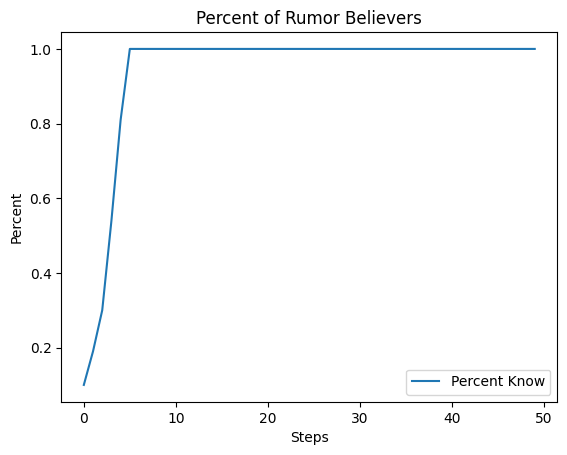

In [6]:
g = sns.lineplot(df)
g.set(title = "Percent of Rumor Believers", xlabel = "Steps", ylabel ="Percent")

In [7]:
from mesa.experimental import JupyterViz

def agent_portrayal(agent):
    size = 50
    color = "tab:blue"
    layer = 0
    if agent.heardRumor:
        color = "tab:red"
        layer = 1
    return {"size": size, "color": color, "layer": layer}

model_params = {
    "N": {
        "type": "SliderInt",
        "value": 100,
        "label": "Number of Agents",
        "min": 10,
        "max": 200,
        "step": 1
    },
    "width": {
        "type": "SliderInt",
        "value": 10,
        "label": "Width",
        "min": 1,
        "max": 50,
        "step": 1
    },
    "height": {
        "type": "SliderInt",
        "value": 10,
        "label": "Height",
        "min": 1,
        "max": 50,
        "step": 1
    },
    "numRumored" : {
        "type" : "SliderInt",
        "value": 10,
        "label": "Number Who Start Rumor",
        "min": 1,
        "max": 100,
        "step": 1
    },
    "spreadChance" : {
        "type" : "SliderFloat",
        "value": .5,
        "label": "Spread Chance",
        "min": 0.1,
        "max": 1,
        "step": 0.1
    },
    "trPStart" : {
        "type" : "SliderFloat",
        "value": 0.8,
        "label": "Middle of Trust Percent Distribution",
        "min": 0.1,
        "max": 1.0,
        "step": .1
    },
    "trPRange" : {
        "type" : "SliderFloat",
        "value": 0.3,
        "label": "Standard Deviation of Trust Percent",
        "min": 0.1,
        "max": 1,
        "step": .1
    }
}

page = JupyterViz(
    RumorModel,
    model_params,
    measures = ["Percent Know"],
    name = "Rumor Model",
    agent_portrayal = agent_portrayal

)
page

Html(layout=None, style_='display: none', tag='span')

Cannot show ipywidgets in text